### Tutorial 4: Regression Analysis using Python statsmodel 

Regression analysis is a statistical technique used to model and analyze relationships between variables. It allows us to quantify the impact of one or more independent variables on a dependent variable and is widely used in various fields such as economics, biology, and social sciences.

This tutorial focuses on implementing regression models with the Python library `statsmodels`, complemented by visualizations using `seaborn` to effectively interpret and communicate the results.

##### Terminology

- **Independent Variable(s)**: The predictors or factors that explain variations.
- **Dependent Variable**: The outcome being modeled or predicted.



In [17]:
import sqlite3
import pandas as pd

db_path = './database/mmdt.db3'

conn = sqlite3.connect(db_path)
query = """
        SELECT 
                p.ID, 
                COALESCE(p.Gender, b.Gender) as gender,
                COALESCE(p.BOD, b.BOD) as birth_year,
                COALESCE(p.Pre_Knowledge_Data, b.Pre_Knowledge_Data) as pre_score,
                COALESCE(p.Device_used, b.Device_used) as device_used,
                COALESCE(a.Rate, '0%') as attendance
                FROM participants as p
                LEFT JOIN bhutan as b                
                ON p.ID = b.ID
                LEFT JOIN attendance as a
                ON LOWER(a.ID) = LOWER(p.ID);
        """

df = pd.read_sql_query(query, conn)
conn.close()

df['attendance'] = df['attendance'].apply(lambda data:data.replace('%',''))
df['attendance'] =  df['attendance'].astype('float64')
df['gender'] = df['gender'].str.strip()
df['gender'] = df['gender'].str.title()
df['gender'] = df['gender'].apply(lambda sex: 'Male' if sex == 'Man' else sex)

df['birth_year'] = df['birth_year'].astype('category')
df['birth_year'] = df['birth_year'].apply(lambda data: str(data).split('/')[2] if '/' in str(data) else data)
df['birth_year'] = df['birth_year'].astype('int')
df['age'] = 2024-df['birth_year']

In [18]:
df['device_used'] = df['device_used'].str.strip().str.lower()
df_split = df['device_used'].str.split(',', expand=True).reset_index(drop=True)
df_split.columns = [f'device_{k}' for k in range(df_split.shape[1])]

device_mapping = {
    'my own computer': 'my own computer',
    'mobile phone / table': 'mobile phone/tablet',
    'a borrowed / shared computer': 'borrowed/shared computer',
    'laptop': 'laptop',
    'computer from my organization but i have access to install new tools': 'company provided computer',
    'no need to request approval from it team': None,
    'laptop provided from current job': 'company provided laptop'
}
for col in df_split.columns:
    df_split[col] = df_split[col].str.strip()
    df_split[col] = df_split[col].map(device_mapping)

df_split['device_count'] = 3 - df_split.isna().sum(axis = 1)
df_model = df[['age', 'pre_score', 'attendance']].copy()
df_model['device_count'] = df_split['device_count']
df_model.loc[df['age']<0, 'age'] = 2024-1983
df_model



,age,pre_score,attendance,device_count
0,32,1.0,100.0,1
1,25,3.0,100.0,1
2,38,2.0,100.0,1
3,27,1.0,83.0,2
4,25,1.0,50.0,1
...,...,...,...,...
95,25,3.0,0.0,1
96,24,2.0,0.0,1
97,27,0.0,100.0,1
98,25,1.0,100.0,1


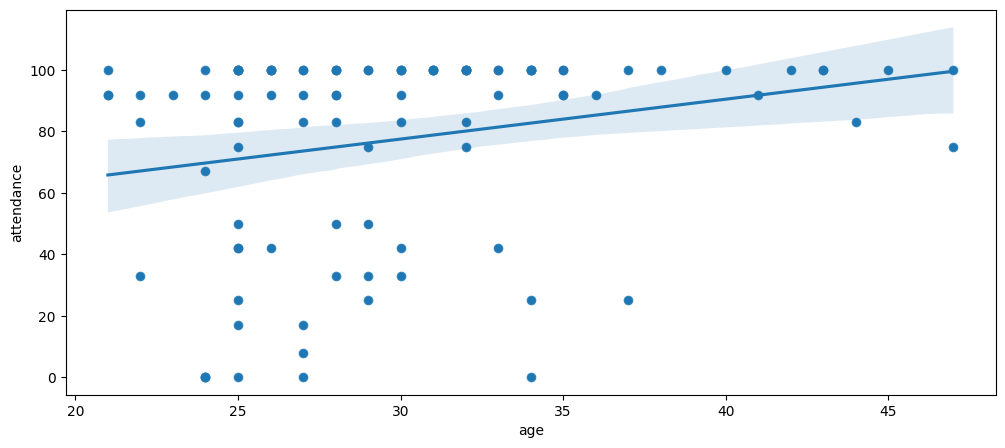

In [39]:
import statsmodels.formula.api as stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12,5))
sns.scatterplot(data = df_model, x = 'age', y = 'attendance')
sns.regplot(data = df_model, x = 'age', y = 'attendance')
plt.show()



In [45]:
import numpy as np

model = stats.ols("attendance~age", data = df_model).fit()
intercept = model.params['Intercept']
slope = model.params['age']

ages = np.arange(20, 50)
result_df = pd.DataFrame({'age':ages})
y_pred = model.predict(result_df)
y_pred_manual = intercept + slope*ages

result_df['pred'] = y_pred
result_df['pred_m'] = y_pred_manual
result_df = result_df.round(3)



In [47]:
model = stats.ols("attendance~age+pre_score", data = df_model).fit()
print(model.params)

Intercept    37.214345
age           1.305051
pre_score     0.674835
dtype: float64


In [48]:
model = stats.ols("attendance~age:pre_score", data = df_model).fit()
print(model.params)

Intercept        70.938393
age:pre_score     0.125937
dtype: float64


In [49]:
model = stats.ols("attendance~age*pre_score", data = df_model).fit()
print(model.params)

Intercept        96.556194
age              -0.670465
pre_score       -34.303688
age:pre_score     1.171914
dtype: float64


## Hypothesis Testing with `statsmodels` for Attendance Prediction

In this example, we have a dataset with the following variables:

- **Independent Variables (X)**: 
  - `device_count`: Number of devices a student used for the training.
  - `age`: Age of the student.
  - `pre_score`: Pre-test score or some other relevant score before the main event.
  
- **Dependent Variable (Y)**: 
  - `attendance`: The attendance rate or count of a student attending an event or class.

### Step 1: Define the Hypotheses

We want to test the following hypotheses for each of the independent variables:

- **Null Hypothesis (H₀)**: The coefficient of each variable is zero (i.e., it has no effect on attendance).
  - $H_0: \beta_{device\_count} = 0 $
  - $H_0: \beta_{age} = 0 $
  - $H_0: \beta_{pre\_score} = 0$

- **Alternative Hypothesis (H₁)**: The coefficient of each variable is non-zero (i.e., it significantly affects attendance).
  - $H_1: \beta_{device\_count} \neq 0 $
  - $H_1: \beta_{age} \neq 0 $
  - $H_1: \beta_{pre\_score} \neq 0$

### Step 2: Fit the Model and Perform Hypothesis Testing

You can use **`statsmodels`** to fit an OLS regression model and perform hypothesis testing on the coefficients. Here's an example using Python:

In [50]:
import statsmodels.api as sm
import pandas as pd

X = df_model[['device_count', 'age', 'pre_score']].copy()
X = sm.add_constant(X)  
y = df_model['attendance']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             attendance   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.059
Date:                Sun, 08 Dec 2024   Prob (F-statistic):              0.111
Time:                        23:24:36   Log-Likelihood:                -485.51
No. Observations:                 100   AIC:                             979.0
Df Residuals:                      96   BIC:                             989.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           30.0279     21.249      1.413   


### Step 3: Interpreting the Results
By performing hypothesis testing using statsmodels, you can assess the statistical significance of the relationships between each of the independent variables (device_count, age, pre_score) and the dependent variable (attendance). In this case, based on the p-values, you can conclude that device_count, age, and pre_score all do not have significant effects on attendance, assuming you set the significance level to 0.05.